<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd

In [19]:
# Исходные данные для моделировния

# Фонтанирующая скважина
p_R_0 = 32.48  # Среднепластовое давление
p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
# p_R = 21  # Среднепластовое давление
# p_G0 = 18  # Давление насыщенного газа

H_R = 3400  # Глубина забоя по вертикали
w_1 = 12.39  # Гидропроводность из пласта в ПЗ скважины
r_R = 1/w_1;
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.41  # Объёмная доля воды

# Удельный вес
gamma_oil = 0.0074  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000078  # газа
G = 100  # Газовый фактор
k_G = 0.8
p_L = 0.75  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.2  # обсадной колонный
r_N = 1.6  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3.7  # устьевого штуцера
r_GU = 3.3  # перепускного клапана

# Параметры насоса
H_N = 1195.2  # уровень подвеса
h_0 = 997  # номинальный напор
q_0 = 90  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.007, 0.82, 0.74]
lambda_3 = [0.79, 0.18, 0.3]

In [20]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []

In [21]:

# Начальное состояние насоса
u = 0
w = 0

num = 1
Q_sum = 0
q = 0

Q_H = 45000
Q_K = 120000
v_R = 0.7

iterations_num = 5000

for k in range(iterations_num):

    Q_sum += q

    if (Q_sum-Q_H)>0 and (Q_sum-Q_K)>0:
        betta = (1/(Q_K-Q_H))*((Q_sum-Q_H)-(Q_sum-Q_K))
    elif (Q_sum-Q_H)>0 and (Q_sum-Q_K)<=0:
        betta = (1/(Q_K-Q_H))*((Q_sum-Q_H))
    else:
        betta = (1/(Q_K-Q_H))

    p_R = p_R_0*(1-v_R*betta)

    gamma = (1-betta)*gamma_oil+betta*gamma_water
    Y_G = (1-betta)*gamma_gas*G

    r12=r_K+((1/w_1)/gamma)
    r21=r12
    r11=r12+r_N+r_U
    r22=r12+r_T+r_GU

    dH_R =  (p_R-p_L)/gamma - H_R
    gh_1 = u*w*w*h_0*lambda_0[num]+dH_R
    gh_2 = dH_R

    R = np.array([[u*w*(h_0/q_0)*lambda_1[num]+r11, r12],
                  [r12+(Y_G/gamma)*r_GU*u*w*k_G, r22]])

    Q = np.linalg.inv(R).dot(np.array([[1], [1]]))

    if dH_R > 0:
        q_N_porog = dH_R/(r12+u*w*(Y_G/gamma)*r_GU*k_G)

        a = h_0*lambda_0[2]
        b = (h_0/q_0)*lambda_1[2]*q_N_porog
        c = r11*q_N_porog - dH_R

        w_porog = (b + np.sqrt(b*b-4*a*c))/(2*a)

        if u*w > 0:
            if w <= w_porog:
                H_4 = 0
                H_8 = 0
                Q = np.linalg.inv(R).dot(np.array([[gh_1], [gh_2]]))
                q_N = Q[0, 0]
                q_T = Q[1, 0]
            else:
                q_T = 0
                H_8 = 0
                if (gh_1/(u*w*(h_0/q_0)*lambda_1[num]+r11)) > 0 :
                    q_N = gh_1/(u*w*(h_0/q_0)*lambda_1[num]+r11)
                else:
                    q_N = 0

            if (((((r_GU*Y_G*k_G+r_R)/gamma)+r_K)*q_N)-dH_R) > 0:
                H_4 = ((((r_GU*Y_G*k_G+r_R)/gamma)+r_K)*q_N)-dH_R
            else:
                H_4 = 0
        else:
            H_4 = 0
            H_8 = 0
            Q = np.linalg.inv(R).dot(np.array([[gh_1], [gh_2]]))
            q_N = Q[0, 0]
            q_T = Q[1, 0]


    else:
        w_0 = np.sqrt(-dH_R/(h_0*lambda_0[2]))
        if u*w > 0:
            if w < w_0:
                H_4 = -dH_R
                H_8 = -dH_R - w*w*h_0*lambda_0[2]
                q_N = 0
                q_T = 0

            else:
                q_T = 0
                H_8 = 0
                if (gh_1/(u*w*(h_0/q_0)*lambda_1[num]+r11)) > 0:
                    q_N = gh_1/(u*w*(h_0/q_0)*lambda_1[num]+r11)
                else:
                    q_N = 0

                if ((((r_GU*Y_G*k_G)/gamma)*q_N)-dH_R) > 0:
                    H_4 = ((((r_GU*Y_G*k_G+r_R)/gamma)+r_K)*q_N)-dH_R
                else:
                    H_4 = 0


        else:
            H_4 = -dH_R
            H_8 = -dH_R
            q_N = 0
            q_T = 0

    q = q_N + q_T
    if q >= w*q_0*q_Pump[1] and q <= w*q_0*q_Pump[0]:
        num = 0
    elif q > w*q_0*q_Pump[2] and q < w*q_0*q_Pump[1]:
        num = 1
    else:
        num = 2

    p_1 = p_R - r_R*(q_N+q_T)
    p_3 = p_1 - gamma*(H_R-H_N+r_K*(q_N+q_T))
    p_5 = p_L + gamma * H_N + gamma*(r_N+r_U)*q_N
    p_4 = p_L + r_GU*(Y_G*u*k_G*q_N+gamma*q_T)
    p_8 = p_L + gamma*r_U*q_N

    _q_N.append(q_N)
    _q_T.append(q_T)
    _p_3.append(p_3)

    if k == 1500:
      u = 1
      w = 1

    _u.append(u)



<ipython-input-21-c8e4318304fd>:52: RuntimeWarning: invalid value encountered in sqrt
  w_porog = (b + np.sqrt(b*b-4*a*c))/(2*a)


In [22]:
df = pd.DataFrame({'q_N': _q_N, 'q_T': _q_T, 'p_3': _p_3, 'u': _u})

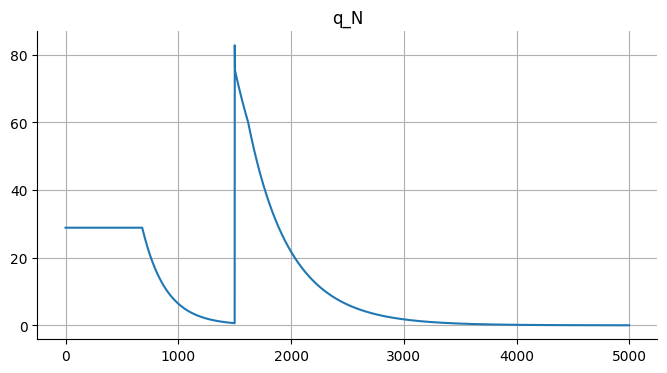

In [26]:
from matplotlib import pyplot as plt
df['q_N'].plot(kind='line', figsize=(8, 4), title='q_N', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

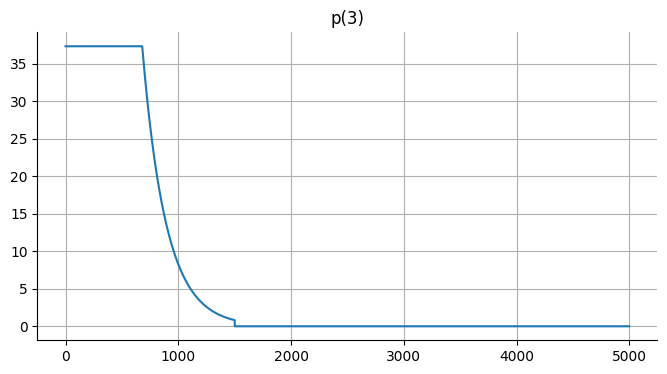

In [27]:
from matplotlib import pyplot as plt
df['q_T'].plot(kind='line', figsize=(8, 4), title='p(3)', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

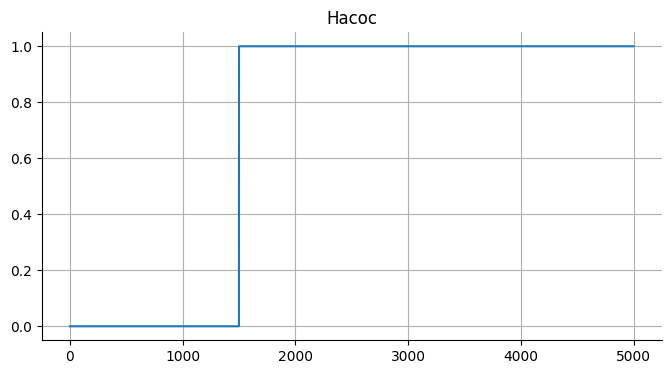

In [25]:
from matplotlib import pyplot as plt
df['u'].plot(kind='line', figsize=(8, 4), title='Насос', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)